In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
#from geopy.geocoders import Nominatim
#from geopy.exc import GeocoderTimedOut

import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV,train_test_split , KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:

df_host = pd.read_csv('host_data.csv')
df_loc = pd.read_csv('location_data.csv')
df_pric = pd.read_csv('pricing_data.csv')
df_prop = pd.read_csv('property_data.csv')
df_rev = pd.read_csv('review_data.csv')

In [3]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.isna().sum())

customer_id                   0
host_since                  173
host_response_rate        17193
host_has_profile_pic        173
host_identity_verified      173
dtype: int64
customer_id         0
neighbourhood    9550
latitude            0
longitude           0
city                0
zipcode           894
dtype: int64
customer_id            0
log_price              0
cleaning_fee           0
cancellation_policy    0
dtype: int64
customer_id        0
property_type      0
room_type          0
bedrooms          83
bathrooms        182
accommodates       0
beds             113
dtype: int64
customer_id                 0
number_of_reviews           0
review_scores_rating    15733
first_review            14932
last_review             14896
dtype: int64


In [4]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.shape)
    print(i.head(1))

(69546, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(69546, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(69546, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(69546, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [5]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(subset=['customer_id'], keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} duplicate rows based on 'customer_id'")

DataFrame 1: 2728 duplicate rows based on 'customer_id'
DataFrame 2: 2728 duplicate rows based on 'customer_id'
DataFrame 3: 2728 duplicate rows based on 'customer_id'
DataFrame 4: 2728 duplicate rows based on 'customer_id'
DataFrame 5: 2728 duplicate rows based on 'customer_id'


In [6]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} fully identical rows")

DataFrame 1: 2728 fully identical rows
DataFrame 2: 2728 fully identical rows
DataFrame 3: 2728 fully identical rows
DataFrame 4: 2728 fully identical rows
DataFrame 5: 2728 fully identical rows


In [7]:
df_host = df_host.drop_duplicates(keep='first')
df_loc = df_loc.drop_duplicates(keep='first')
df_pric = df_pric.drop_duplicates(keep='first')
df_prop = df_prop.drop_duplicates(keep='first')
df_rev = df_rev.drop_duplicates(keep='first')
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]

In [8]:
for i in dfs:
    print(i.shape)
    print(i.head(1))

(68182, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(68182, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(68182, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(68182, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [9]:
df = df_host.merge(df_loc, on='customer_id', how='inner') \
                   .merge(df_pric, on='customer_id', how='inner') \
                   .merge(df_rev, on='customer_id', how='inner') \
                   .merge(df_prop, on='customer_id', how='inner')
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [10]:
df['review_scores_rating'] = df['review_scores_rating'].fillna(50)

In [11]:
df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)
df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0], inplace=True)

df.loc[:, 'host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df.loc[:, 'host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_response_rate'].isna().sum()

df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since'] = (pd.to_datetime(datetime.now()) - df['host_since']).dt.days / 365
df['host_since'] = df['host_since'].fillna(df['host_since'].median())

C:\Users\fedor\AppData\Local\Temp\ipykernel_3868\3929864502.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)
C:\Users\fedor\AppData\Local\Temp\ipykernel_3868\3929864502.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [12]:
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])

df['bedrooms'] = df['bedrooms'].replace(-1, 1)


In [13]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood              9368
latitude                      0
longitude                     0
city                          0
zipcode                     876
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating          0
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                      0
bathrooms                     0
accommodates                  0
beds                          0
dtype: int64

In [14]:
#df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.rstrip('%'))
#Change host_since to a numeric value ( we calculate the duration)
#df['host_since'] = ((pd.to_datetime(datetime.now()) - df['host_since']).dt.days) / 365
#Change t/f to True and False
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'t': True, 'f': False}).astype(bool)
df['host_identity_verified'] = df['host_identity_verified'].map({'t': True, 'f': False}).astype(bool)
#Capatalize values in room_type and property_type to have a uniform standard between values
df['room_type'] = df['room_type'].str.upper()
df['property_type'] = df['property_type'].str.upper()

filled_loc_data = 'loc_data_filled.csv'
geolocator = Nominatim(user_agent="lazaniaa7@gmail.com")
        
def get_zipcode(lat, lon):
     try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and 'postcode' in location.raw['address']:
           return location.raw['address']['postcode']
     except GeocoderTimedOut:
        return None
     return None


if os.path.exists(filled_loc_data):
     df = pd.read_csv(filled_loc_data , index = False)
else:
    for idx, row in df[df['zipcode'].isna()].iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            zipcode = get_zipcode(row['latitude'], row['longitude'])
            df.at[idx, 'zipcode'] = zipcode

    
    
    


for i in df['zipcode'][df['neighbourhood'].isna()]:
         try:
             df.loc[(df_loc['zipcode'] == i) & (df['neighbourhood'].isna()), 'neighbourhood'] = df['neighbourhood'][df['zipcode'] == i].mode()[0]
         except:
             #NNF = NO NEIGHBOURHOOD FOUND
            df.loc[(df_loc['zipcode'] == i) & (df['neighbourhood'].isna()), 'neighbourhood'] = 'NNF'



In [17]:
print(df.shape)
print(df.duplicated().sum())


(68182, 23)
0


In [18]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood              9368
latitude                      0
longitude                     0
city                          0
zipcode                     876
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating          0
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                      0
bathrooms                     0
accommodates                  0
beds                          0
dtype: int64

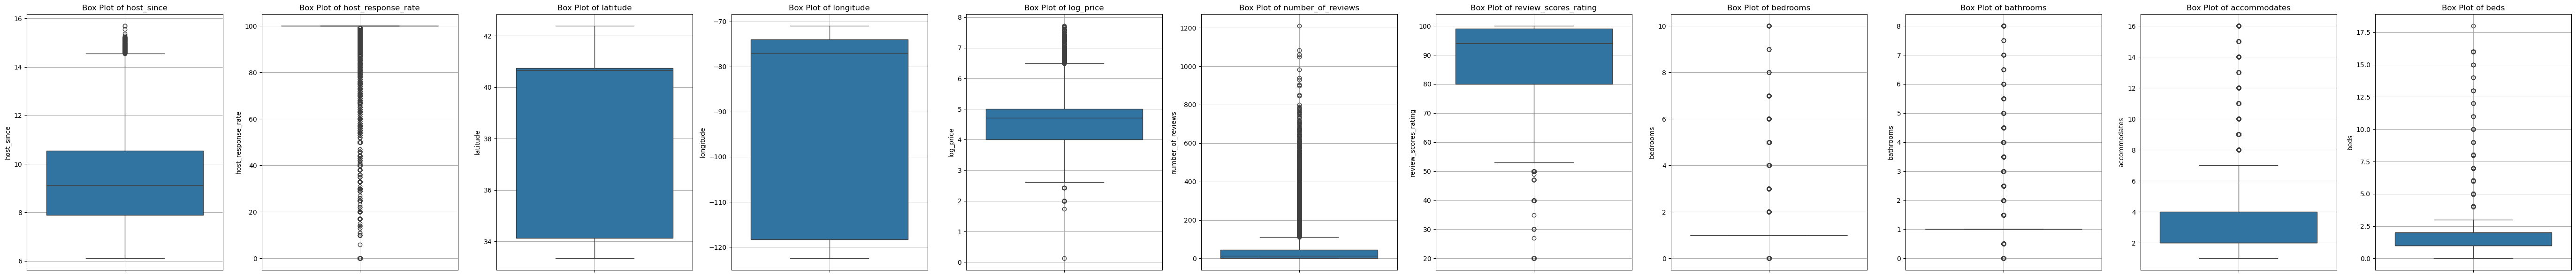

In [19]:
numerical_cols = df.select_dtypes(include=['number']).columns

num_cols = len(numerical_cols)
fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 6))
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')
    ax.set_ylabel(col)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [20]:
cols_to_drop = ['customer_id' , 'latitude','longitude','zipcode' , 'first_review' , 'last_review' , 'neighbourhood']
df = df.drop(columns=cols_to_drop, axis = 1)

In [21]:
categorical_columns = [ 'city', 'cancellation_policy', 'property_type', 'room_type']

df_with_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [22]:
model_scores = {}
X = df_with_dummies.drop(columns=['log_price'])
y = df_with_dummies['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
saved_model_name = 'model_lr_TUNED.joblib'

param_grid = {
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr_TUNED = loaded_model
else:
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    model_lr_TUNED = grid_search.best_estimator_
    joblib.dump(model_lr_TUNED, saved_model_name)

y_pred = model_lr_TUNED.predict(X_test)

train_score = model_lr_TUNED.score(X_train, y_train)
test_score = model_lr_TUNED.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

params = model_lr_TUNED.get_params()

model_scores['Linear Regression TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used Parameters': params
}

print(f"Train Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Train Score (R²): 0.46647205117873847
Test Score (R²): 0.4691889221554747
Mean Squared Error: 0.32746606758439456
R² Score: 0.4691889221554747


In [24]:
saved_model_name_ridge = 'model_ridge_TUNED.joblib'
saved_model_name_lasso = 'model_lasso_TUNED.joblib'

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Ridge Regression
if os.path.exists(saved_model_name_ridge):
    model_ridge_TUNED = joblib.load(saved_model_name_ridge)
else:
    grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
    grid_search_ridge.fit(X_train, y_train)
    model_ridge_TUNED = grid_search_ridge.best_estimator_
    joblib.dump(model_ridge_TUNED, saved_model_name_ridge)

y_pred_ridge = model_ridge_TUNED.predict(X_test)

train_score_ridge = model_ridge_TUNED.score(X_train, y_train)
test_score_ridge = model_ridge_TUNED.score(X_test, y_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

params_ridge = model_ridge_TUNED.get_params()

model_scores['Ridge Regression TUNED'] = {
    'Train Score': train_score_ridge,
    'Test Score': test_score_ridge,
    'Mean Squared Error': mse_ridge,
    'R2 Score': r2_ridge,
    'Used Parameters': params_ridge
}

print(f"Ridge Regression - Train Score (R²): {train_score_ridge}")
print(f"Ridge Regression - Test Score (R²): {test_score_ridge}")
print(f"Ridge Regression - Mean Squared Error: {mse_ridge}")
print(f"Ridge Regression - R² Score: {r2_ridge}")



Ridge Regression - Train Score (R²): 0.46645865770749095
Ridge Regression - Test Score (R²): 0.46926178397378415
Ridge Regression - Mean Squared Error: 0.327421117932598
Ridge Regression - R² Score: 0.46926178397378415


In [25]:
if os.path.exists(saved_model_name_lasso):
    model_lasso_TUNED = joblib.load(saved_model_name_lasso)
else:
    grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
    grid_search_lasso.fit(X_train, y_train)
    model_lasso_TUNED = grid_search_lasso.best_estimator_
    joblib.dump(model_lasso_TUNED, saved_model_name_lasso)

y_pred_lasso = model_lasso_TUNED.predict(X_test)

train_score_lasso = model_lasso_TUNED.score(X_train, y_train)
test_score_lasso = model_lasso_TUNED.score(X_test, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

params_lasso = model_lasso_TUNED.get_params()

model_scores['Lasso Regression TUNED'] = {
    'Train Score': train_score_lasso,
    'Test Score': test_score_lasso,
    'Used Parameters': params_lasso
}

print(f"Lasso Regression - Train Score (R²): {train_score_lasso}")
print(f"Lasso Regression - Test Score (R²): {test_score_lasso}")
print(f"Lasso Regression - Mean Squared Error: {mse_lasso}")
print(f"Lasso Regression - R² Score: {r2_lasso}")

Lasso Regression - Train Score (R²): 0.4444015137041568
Lasso Regression - Test Score (R²): 0.44205013714942454
Lasso Regression - Mean Squared Error: 0.3442084295581448
Lasso Regression - R² Score: 0.44205013714942454


In [26]:
saved_model_name_elastic = 'model_elastic_TUNED.joblib'

param_grid_elastic = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'fit_intercept': [True, False]
}

# Elastic Net Regression
if os.path.exists(saved_model_name_elastic):
    model_elastic_TUNED = joblib.load(saved_model_name_elastic)
else:
    grid_search_elastic = GridSearchCV(ElasticNet(), param_grid_elastic, cv=5)
    grid_search_elastic.fit(X_train, y_train)
    model_elastic_TUNED = grid_search_elastic.best_estimator_
    joblib.dump(model_elastic_TUNED, saved_model_name_elastic)

y_pred_elastic = model_elastic_TUNED.predict(X_test)

train_score_elastic = model_elastic_TUNED.score(X_train, y_train)
test_score_elastic = model_elastic_TUNED.score(X_test, y_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

params_elastic = model_elastic_TUNED.get_params()
alpha_used = params_elastic['alpha']
l1_ratio_used = params_elastic['l1_ratio']

model_scores['Elastic Net Regression TUNED'] = {
    'Train Score': train_score_elastic,
    'Test Score': test_score_elastic,
    'Used Parameters': params_elastic
}

print(f"Elastic Net Regression - Train Score (R²): {train_score_elastic}")
print(f"Elastic Net Regression - Test Score (R²): {test_score_elastic}")
print(f"Elastic Net Regression - Mean Squared Error: {mse_elastic}")
print(f"Elastic Net Regression - R² Score: {r2_elastic}")
print(f"Elastic Net Regression - Lambda (Alpha): {alpha_used}")
print(f"Elastic Net Regression - L1 Ratio: {l1_ratio_used}")


Elastic Net Regression - Train Score (R²): 0.45717304774182643
Elastic Net Regression - Test Score (R²): 0.45708076459938873
Elastic Net Regression - Mean Squared Error: 0.3349357887452349
Elastic Net Regression - R² Score: 0.45708076459938873
Elastic Net Regression - Lambda (Alpha): 0.01
Elastic Net Regression - L1 Ratio: 0.1


In [27]:
saved_model_name_dt = 'model_dt_TUNED.joblib'

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

# Decision Tree Regression with GridSearchCV
if os.path.exists(saved_model_name_dt):
    model_dt_TUNED = joblib.load(saved_model_name_dt)
else:
    grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5)
    grid_search_dt.fit(X_train, y_train)
    model_dt_TUNED = grid_search_dt.best_estimator_
    joblib.dump(model_dt_TUNED, saved_model_name_dt)

y_pred_dt = model_dt_TUNED.predict(X_test)

train_score_dt = model_dt_TUNED.score(X_train, y_train)
test_score_dt = model_dt_TUNED.score(X_test, y_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

params_dt = model_dt_TUNED.get_params()

model_scores['Decision Tree Regression TUNED'] = {
    'Train Score': train_score_dt,
    'Test Score': test_score_dt,
    'Used Parameters': params_dt
}

print(f"Decision Tree Regression - Train Score (R²): {train_score_dt}")
print(f"Decision Tree Regression - Test Score (R²): {test_score_dt}")
print(f"Decision Tree Regression - Mean Squared Error: {mse_dt}")
print(f"Decision Tree Regression - R² Score: {r2_dt}")
print(f"Decision Tree Regression - Best Parameters: {params_dt}")

Decision Tree Regression - Train Score (R²): 0.5232513296069765
Decision Tree Regression - Test Score (R²): 0.4691002146908002
Decision Tree Regression - Mean Squared Error: 0.3275207926755518
Decision Tree Regression - R² Score: 0.4691002146908002
Decision Tree Regression - Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [28]:
saved_model_name_rf = 'model_rf_TUNED.joblib'

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Random Forest Regression with GridSearchCV
if os.path.exists(saved_model_name_rf):
    model_rf_TUNED = joblib.load(saved_model_name_rf)
else:
    grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
    grid_search_rf.fit(X_train, y_train)
    model_rf_TUNED = grid_search_rf.best_estimator_
    joblib.dump(model_rf_TUNED, saved_model_name_rf)

y_pred_rf = model_rf_TUNED.predict(X_test)

train_score_rf = model_rf_TUNED.score(X_train, y_train)
test_score_rf = model_rf_TUNED.score(X_test, y_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

params_rf = model_rf_TUNED.get_params()

model_scores['Random Forest Regression TUNED'] = {
    'Train Score': train_score_rf,
    'Test Score': test_score_rf,
    'Used Parameters': params_rf
}

print(f"Random Forest Regression - Train Score (R²): {train_score_rf}")
print(f"Random Forest Regression - Test Score (R²): {test_score_rf}")
print(f"Random Forest Regression - Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression - R² Score: {r2_rf}")
print(f"Random Forest Regression - Best Parameters: {params_rf}")

Random Forest Regression - Train Score (R²): 0.5445314346325949
Random Forest Regression - Test Score (R²): 0.5003686303273667
Random Forest Regression - Mean Squared Error: 0.30823079377485074
Random Forest Regression - R² Score: 0.5003686303273667
Random Forest Regression - Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
saved_model_name_gb = 'model_gb_TUNED.joblib'

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting Regression with GridSearchCV
if os.path.exists(saved_model_name_gb):
    model_gb_TUNED = joblib.load(saved_model_name_gb)
else:
    grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
    grid_search_gb.fit(X_train, y_train)
    model_gb_TUNED = grid_search_gb.best_estimator_
    joblib.dump(model_gb_TUNED, saved_model_name_gb)

y_pred_gb = model_gb_TUNED.predict(X_test)

train_score_gb = model_gb_TUNED.score(X_train, y_train)
test_score_gb = model_gb_TUNED.score(X_test, y_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

params_gb = model_gb_TUNED.get_params()

model_scores['Gradient Boosting Regression TUNED'] = {
    'Train Score': train_score_gb,
    'Test Score': test_score_gb,
    'Used Parameters': params_gb
}

print(f"Gradient Boosting Regression - Train Score (R²): {train_score_gb}")
print(f"Gradient Boosting Regression - Test Score (R²): {test_score_gb}")
print(f"Gradient Boosting Regression - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting Regression - R² Score: {r2_gb}")
print(f"Gradient Boosting Regression - Best Parameters: {params_gb}")

In [ ]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0.5, 1)
plt.legend()
plt.show()

In [ ]:
best_model = max(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the best model -', best_model)
print(model_scores[best_model]['Train Score']) 
print(model_scores[best_model]['Test Score'])
print(model_scores[best_model]['Used parameters']) 

worst_model = min(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the worst model -', worst_model)
print(model_scores[worst_model]['Train Score']) 
print(model_scores[worst_model]['Test Score'])
print(model_scores[worst_model]['Used parameters']) 